# ECG Signal Processing - Peaks Identification

## Methodology:
### The main steps in identifying the peaks in the signal are the followings:
### We eliminate the noise in the signal first. This action gives us a more clear signal to calculate the derivatives. The peaks in the derivatives gives us the points in the signal that are slightly before the peaks in the ECG signal. Therefore, by locating the peaks in the derivatives, we can locate the peaks in the ECG signal. 

### We import the code that we have written for this in the "ecg_peaks_pqrst.py" file. It comprises two functions: 1. "ecg_peaks()" which identifies the R, P, and T peak values, and 2. "plot.peaks()" that plots the signal and the peaks. This file is well-commented and provides more insight into our methodology.

### It is usually hard (and likely impossible) to set a threshold for the peak values (even for R values) as the signal range may change over time. Therefore, using a combination of maximum signal value and mean peak values in the derivative signal, we set a threshold for signal value to identify R peaks and using the mean of distinces between peak values that are above the signal threshold, we calculate a distance threshold (time distance) that should be between R peaks. Using both these thresholds we can then identify R peaks with a good confidence.

### With a similar analogy we locate P and T peaks in the signal as well. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy.signal as scs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ecg_peaks_pqrst as pqrst

#### Reading the input file, while setting the column names.

In [2]:
column_names = ['time', 'v5', 'ml2']
ecg = pd.read_csv('ecg_wave.csv', names = column_names, skiprows = 1, encoding='windows-1252')
ecg

,time,v5,ml2
0,01:13.1,-0.230,-0.220
1,01:13.1,-0.225,-0.235
2,01:13.2,-0.225,-0.250
3,01:13.2,-0.205,-0.250
4,01:13.2,-0.220,-0.235
...,...,...,...
3595,01:23.1,-0.350,-0.355
3596,01:23.1,-0.345,-0.360
3597,01:23.1,-0.340,-0.360
3598,01:23.1,-0.335,-0.350


#### The time column has low accuracy. A visual inspection and simple statistics in Linux Bash showed that in each tenth of a second there are 35 to 37 data points. This results in time-series plots that are hard to comprehend, as can be seen below. 

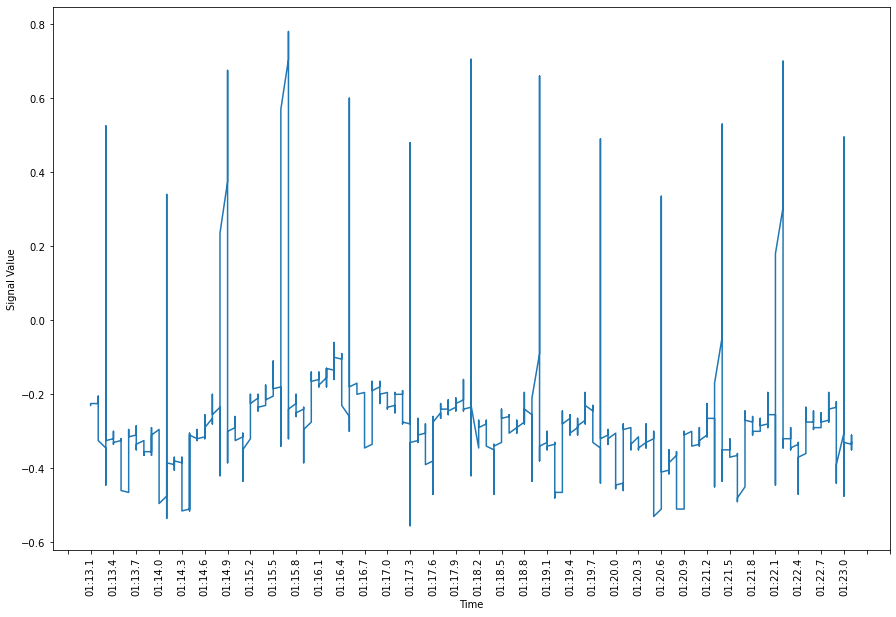

In [3]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize = (15,10))
plt.xlabel('Time')
plt.ylabel('Signal Value')
plt.xticks(rotation = 90)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))
plt.plot(ecg['time'], ecg['v5'])

#### Therefore, we create another column, named "steps", that assigns a distinct steps to each data point, based on the total elapsed time (10 seconds) and number of data points (3600).

In [4]:
t1 = datetime.strptime(ecg['time'].iloc[0], "%M:%S.%f")
t2 = datetime.strptime(ecg['time'].iloc[-1], "%M:%S.%f")
elapsed = t2 - t1

delta = elapsed.total_seconds() / len(ecg)

lst = []
for i in range(len(ecg)):
    lst.append(float(t1.strftime("%S.%f")) + i * delta)

ecg['steps'] = lst
ecg

,time,v5,ml2,steps
0,01:13.1,-0.230,-0.220,13.100000
1,01:13.1,-0.225,-0.235,13.102778
2,01:13.2,-0.225,-0.250,13.105556
3,01:13.2,-0.205,-0.250,13.108333
4,01:13.2,-0.220,-0.235,13.111111
...,...,...,...,...
3595,01:23.1,-0.350,-0.355,23.086111
3596,01:23.1,-0.345,-0.360,23.088889
3597,01:23.1,-0.340,-0.360,23.091667
3598,01:23.1,-0.335,-0.350,23.094444


#### Now plotting the signal value with the calculated steps shows a graph which is easier to understand and to visually inspect the results.

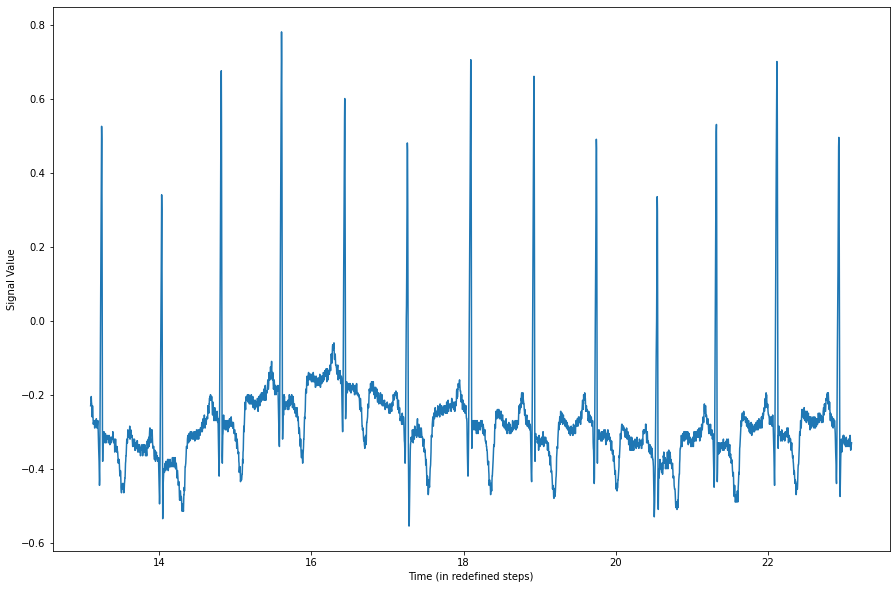

In [5]:
%matplotlib inline
plt.figure(figsize = (15,10))
plt.xlabel('Time (in redefined steps)')
plt.ylabel('Signal Value')
plt.plot(ecg['steps'], ecg['v5'])

#### This signal has very frequent fluctuations that can be categorized as noise (we do not know whether or not the noise has been removed from this signal. But visual inspection implies that it has noise.) Noise is problematic in our methodology to identify peak values. So we first eliminate noise using the "butter" method of SciPy and a critical frequency value (Wn) that works best with our data. We choose the lowpass filter to filter out the higher frequencies than the Wn value.

In [6]:
Wn = 0.15
b, a = scs.butter(4, Wn, 'low', analog = False)
filt_noise_ecg = scs.filtfilt(b, a, ecg.v5)

#### We now pass the filtered signal, along with the original signal and the time/steps values to the "ecg_peaks" function that we have written to locate R, P, and T peaks. 

In [7]:
R_peaks_v5, P_peaks_v5, T_peaks_v5 = pqrst.ecg_peaks(ecg.v5, filt_noise_ecg)

#### Using the "plot_peaks" function that we have written, we plot the signal and the peak values. Arguments are the time/steps array, the original signal (V5), and the calculated peak values of R, P, and T.

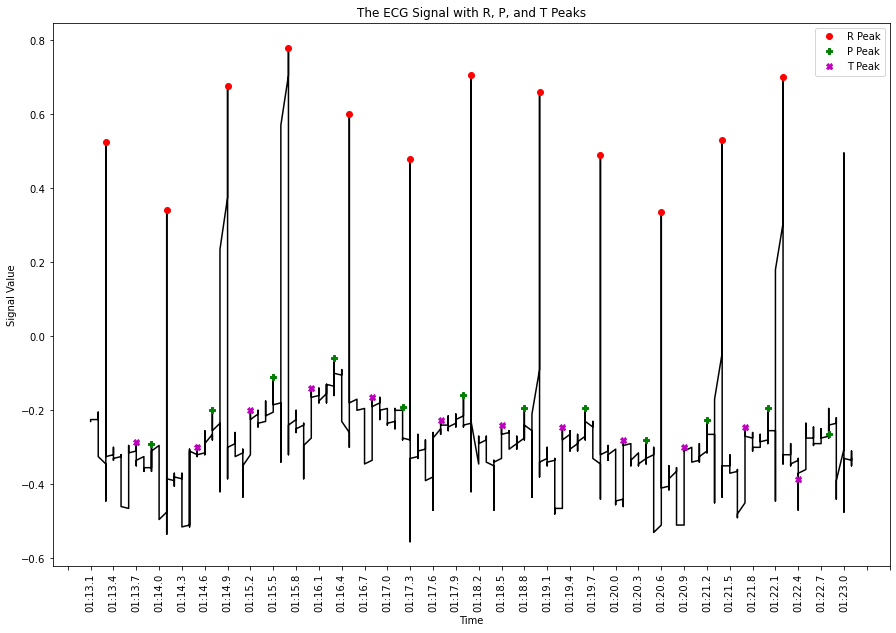

In [8]:
%matplotlib inline
pqrst.plot_peaks(ecg.time, ecg.v5, R_peaks_v5, P_peaks_v5, T_peaks_v5)

#### Again, using the steps instead of time can give us a better graph.

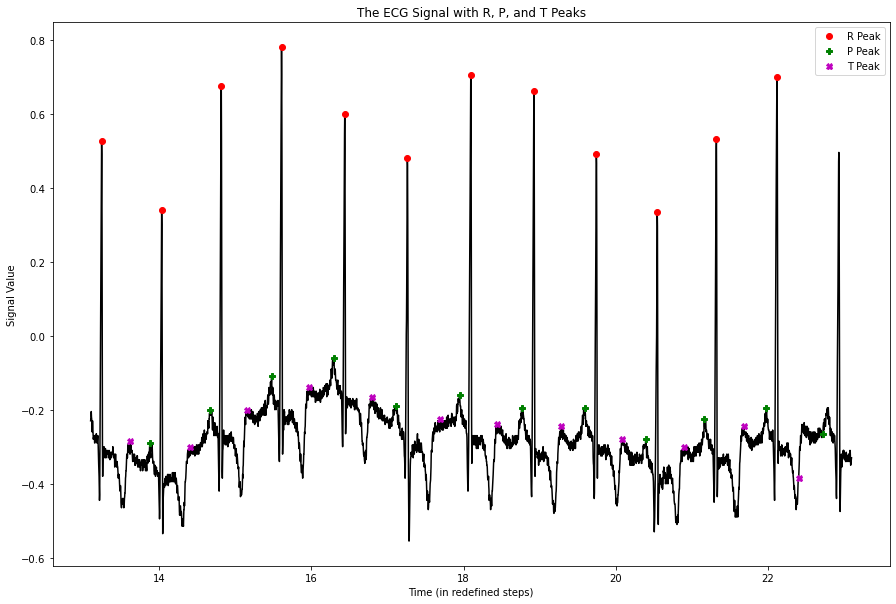

In [10]:
%matplotlib inline
pqrst.plot_peaks(ecg.steps, ecg.v5, R_peaks_v5, P_peaks_v5, T_peaks_v5)

#### We do the same process for the MLII signal values to see how the peaks are identified in that signal.

In [11]:
R_peaks_ml2, P_peaks_ml2, T_peaks_ml2 = pqrst.ecg_peaks(ecg.ml2, filt_noise_ecg)

#### Similar to the previous case, first plotting the data with time values.

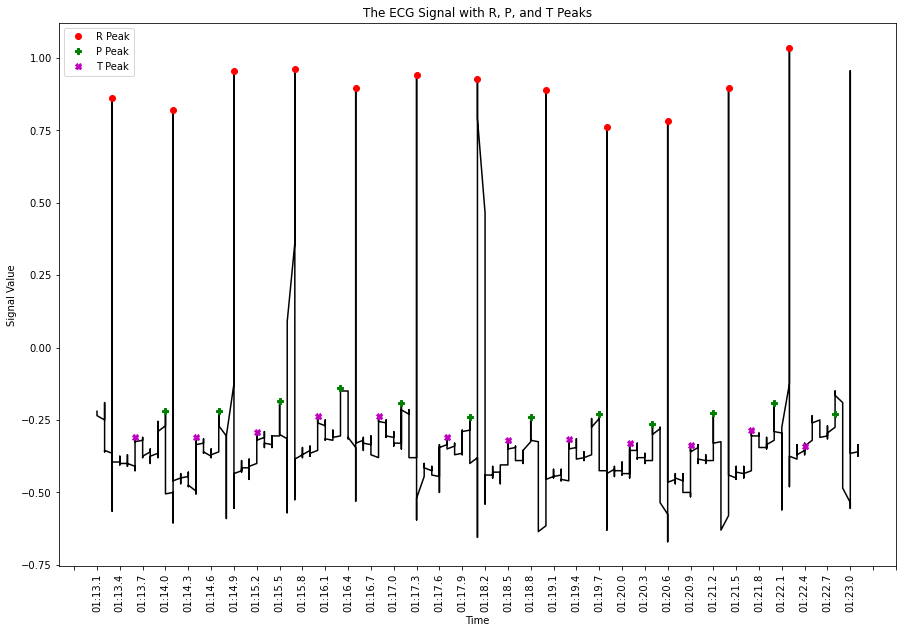

In [12]:
%matplotlib inline
pqrst.plot_peaks(ecg.time, ecg.ml2, R_peaks_ml2, P_peaks_ml2, T_peaks_ml2)

#### Now plotting with step values to see a better graph.

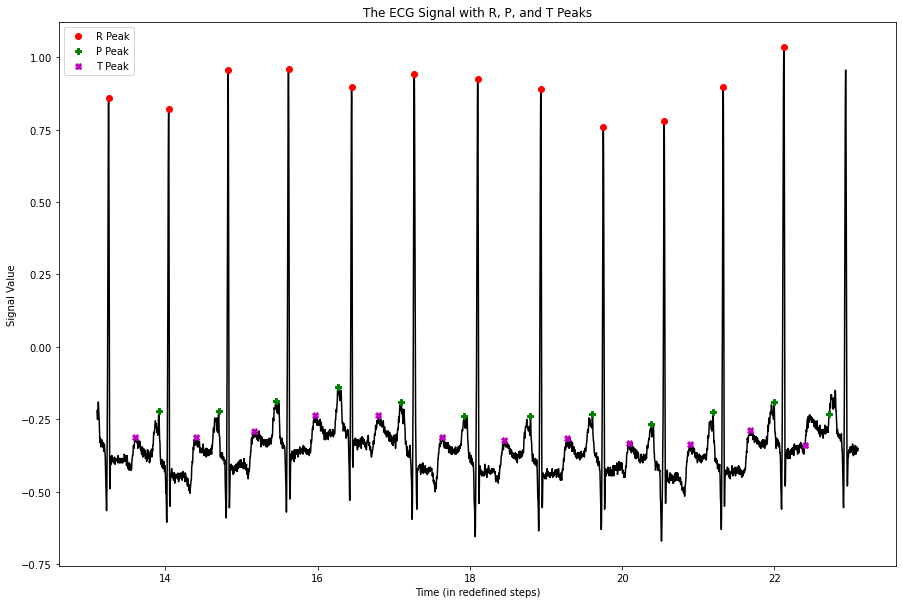

In [14]:
%matplotlib inline
pqrst.plot_peaks(ecg.steps, ecg.ml2, R_peaks_ml2, P_peaks_ml2, T_peaks_ml2)

## False Positive, False Negative, and True Positive rates

### The given assessment is not clear in how we should calculate these rates. Usually, in order to calculate these rates and assess our methodology, we need labeled data that provides ground truth to compare our findings (or predictions in ML models) against the actual (or correct) values. In this particular case, the data is not labeled (i.e., peaks are not given). Therefore, the only way that comes to mind to address this is to calculate these rates, simply by visual inspection. Visually, we can see that our method correctly locates all R peaks, except the last peak in the signal, for both V5 and MLII signals. In this particular dataset, there are 13 R peaks and our method identified 12 of them correctly. That gives us 12/13 = 92.3% rate for True Positives and 1/13 = 7.7% for False Negatives. However, these values can dramatically change in favor of True Positives with increase in the number of datapoints. The False Positives rate is 0%. Visual inspection tells us similar stories for the identified P and T peaks. However, for these peaks, the very last value is identified incorrectly. That gives us the similar True Positives rate, but 7.7% rate for False Positives and False Negatives.

#### The "R_peaks_v5" give us the indices for the R peaks in the V5 signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [15]:
for i in range(len(R_peaks_v5)):
    print(ecg.time[R_peaks_v5[i]], ecg.v5[R_peaks_v5[i]], ecg.ml2[R_peaks_v5[i]])

01:13.3 0.525 0.455
01:14.1 0.34 0.39
01:14.9 0.675 0.675
01:15.7 0.78 0.63
01:16.5 0.6 0.565
01:17.3 0.48 0.56
01:18.1 0.705 0.615
01:19.0 0.66 0.63
01:19.8 0.49 0.345
01:20.6 0.335 0.305
01:21.4 0.53 0.595
01:22.2 0.7 0.765


#### The "R_peaks_ml2" give us the indices for the R peaks in the MLII signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [16]:
for i in range(len(R_peaks_ml2)):
    print(ecg.time[R_peaks_ml2[i]], ecg.v5[R_peaks_ml2[i]], ecg.ml2[R_peaks_ml2[i]])

01:13.3 -0.045 0.86
01:14.1 -0.25 0.82
01:14.9 0.185 0.955
01:15.7 0.095 0.96
01:16.5 0.215 0.895
01:17.3 0.08 0.94
01:18.1 0.07 0.925
01:19.0 0.24 0.89
01:19.8 -0.03 0.76
01:20.6 -0.26 0.78
01:21.4 0.025 0.895
01:22.2 0.24 1.035


#### The "P_peaks_v5" give us the indices for the P peaks in the V5 signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [17]:
for i in range(len(P_peaks_v5)):
    print(ecg.time[P_peaks_v5[i]], ecg.v5[P_peaks_v5[i]], ecg.ml2[P_peaks_v5[i]])

01:13.9 -0.29 -0.265
01:14.7 -0.2 -0.26
01:15.5 -0.11 -0.23
01:16.3 -0.06 -0.18
01:17.2 -0.19 -0.215
01:18.0 -0.16 -0.265
01:18.8 -0.195 -0.28
01:19.6 -0.195 -0.27
01:20.4 -0.28 -0.295
01:21.2 -0.225 -0.255
01:22.0 -0.195 -0.235
01:22.8 -0.265 -0.23


#### The "P_peaks_ml2" give us the indices for the P peaks in the MLII signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [18]:
for i in range(len(P_peaks_ml2)):
    print(ecg.time[P_peaks_ml2[i]], ecg.v5[P_peaks_ml2[i]], ecg.ml2[P_peaks_ml2[i]])

01:14.0 -0.315 -0.22
01:14.7 -0.23 -0.22
01:15.5 -0.145 -0.185
01:16.3 -0.09 -0.14
01:17.1 -0.195 -0.19
01:18.0 -0.185 -0.24
01:18.8 -0.225 -0.24
01:19.7 -0.24 -0.23
01:20.4 -0.295 -0.265
01:21.2 -0.26 -0.225
01:22.0 -0.225 -0.19
01:22.8 -0.265 -0.23


#### The "T_peaks_v5" give us the indices for the T peaks in the V5 signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [19]:
for i in range(len(T_peaks_v5)):
    print(ecg.time[T_peaks_v5[i]], ecg.v5[T_peaks_v5[i]], ecg.ml2[T_peaks_v5[i]])

01:13.7 -0.285 -0.31
01:14.5 -0.3 -0.315
01:15.2 -0.2 -0.29
01:16.0 -0.14 -0.24
01:16.8 -0.165 -0.25
01:17.7 -0.225 -0.34
01:18.5 -0.24 -0.34
01:19.3 -0.245 -0.34
01:20.1 -0.28 -0.335
01:20.9 -0.3 -0.335
01:21.7 -0.245 -0.285
01:22.4 -0.385 -0.34


#### The "T_peaks_v5" give us the indices for the T peaks in the MLII signal. Using those values, we can see the time, V5, and MLII values of these peaks.

In [20]:
for i in range(len(T_peaks_ml2)):
    print(ecg.time[T_peaks_ml2[i]], ecg.v5[T_peaks_ml2[i]], ecg.ml2[T_peaks_ml2[i]])

01:13.6 -0.305 -0.31
01:14.4 -0.305 -0.31
01:15.2 -0.2 -0.29
01:16.0 -0.145 -0.235
01:16.8 -0.175 -0.235
01:17.7 -0.235 -0.31
01:18.5 -0.245 -0.32
01:19.3 -0.255 -0.315
01:20.1 -0.28 -0.33
01:20.9 -0.3 -0.335
01:21.7 -0.245 -0.285
01:22.4 -0.385 -0.34


### We can also check and see how many times the identified peaks are located within both V5 and MLII signals, and how many times the peaks from the two signals are distant.

In [21]:
corrects_R = wrongs_R = corrects_P = wrongs_P = corrects_T = wrongs_T = 0

for i in range(len(R_peaks_v5)):
    if R_peaks_v5[i] == R_peaks_ml2[i]:
        corrects_R += 1
    else:
        wrongs_R += 1
        
for i in range(len(P_peaks_v5)):
    if P_peaks_v5[i] == P_peaks_ml2[i]:
        corrects_P += 1
    else:
        wrongs_P += 1
        
for i in range(len(T_peaks_v5)):
    if T_peaks_v5[i] == T_peaks_ml2[i]:
        corrects_T += 1
    else:
        wrongs_T += 1
        
print('Number of times the identified R peaks are exactly the same in both V5 and MLII signals: ', corrects_R)
print('Number of times the identified R peaks are slightly distant in V5 and MLII signals: ', wrongs_R)
print('Number of times the identified P peaks are exactly the same in both V5 and MLII signals: ', corrects_P)
print('Number of times the identified P peaks are slightly distant in V5 and MLII signals: ', wrongs_P)
print('Number of times the identified T peaks are exactly the same in both V5 and MLII signals: ', corrects_T)
print('Number of times the identified T peaks are slightly distant in V5 and MLII signals: ', wrongs_T)

Number of times the identified R peaks are exactly the same in both V5 and MLII signals:  0
Number of times the identified R peaks are slightly distant in V5 and MLII signals:  12
Number of times the identified P peaks are exactly the same in both V5 and MLII signals:  1
Number of times the identified P peaks are slightly distant in V5 and MLII signals:  11
Number of times the identified T peaks are exactly the same in both V5 and MLII signals:  4
Number of times the identified T peaks are slightly distant in V5 and MLII signals:  8
